In [99]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import scipy.stats as sps

[*********************100%***********************]  1 of 1 completed


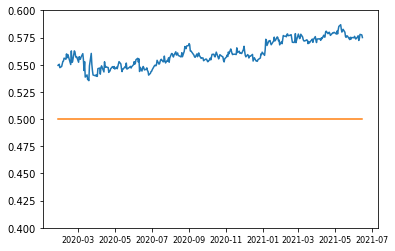

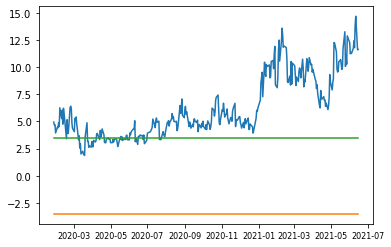

In [101]:
#specifying the maximum power of 2
power = 10
#the rolling sample length
n = 2**power
ticker = '^GSPC' 
start = '2015-12-31'
end = '2021-06-16'
#downloading data
raw_data = yf.download(ticker, start, end)['Close']
prices = np.array(raw_data)[1:]
returns = np.array(raw_data)[1:]/np.array(raw_data)[:-1] - 1
#initialising arrays
hursts = np.array([])
tstats = np.array([])
pvalues = np.array([])
#calculating the rolling Hurst exponent
for t in np.arange(n,len(returns)+1):
    #specifying the subsample
    data = returns[t-n:t]
    X = np.arange(2, power+1)
    Y = np.array([])
    for p in X:
        m = 2**p
        s = 2**(power-p)
        rs_array = np.array([])
        #moving across subsamples
        for i in np.arange(0,s):
            subsample = data[i*m:(i+1)*m]
            mean = np.average(subsample)
            deviate = np.cumsum(subsample-mean)
            difference = max(deviate) - min(deviate)
            stdev = np.std(subsample)
            rescaled_range = difference/stdev
            rs_array = np.append(rs_array, rescaled_range)
        #calculating the log2 of average rescaled range
        Y = np.append(Y, np.log2(np.average(rs_array)))
    reg = sm.OLS(Y, sm.add_constant(X))
    res = reg.fit()
    hurst = res.params[1]
    tstat = (res.params[1]-0.5)/res.bse[1]
    pvalue = 2*(1 - sps.t.cdf(abs(tstat),res.df_resid))
    hursts = np.append(hursts, hurst)
    tstats = np.append(tstats, tstat)
    pvalues = np.append(pvalues, pvalue)
#visualising the Hurst exponent
plt.figure(1)
plt.rc('xtick',labelsize = 8)
plt.ylim(0.4,0.6)
plt.plot(raw_data.index[n:],hursts)
plt.plot(raw_data.index[n:],np.ones(len(hursts))*0.5)
plt.show()
#visualising the t-stat and critical values
plt.figure(2)
plt.rc('xtick',labelsize = 8)
plt.plot(raw_data.index[n:],tstats)
plt.plot(raw_data.index[n:],np.ones(len(tstats))*sps.t.ppf(0.005,res.df_resid))
plt.plot(raw_data.index[n:],np.ones(len(tstats))*sps.t.ppf(0.995,res.df_resid))
plt.show()